In [1]:
%cd /home/rguillaume/developpements/Publications/2024_Guillaume-Castel_PatternEffect_on_TCR

/home/rguillaume/developpements/Publications/2024_Guillaume-Castel_PatternEffect_on_TCR


In [2]:
from dask.distributed import Client
client = Client(n_workers=12)

In [3]:
import lenapy
import xarray as xr 
from xmip.preprocessing import combined_preprocessing, rename_cmip6
from xmip.drift_removal import unify_time
import pandas as pd 
import numpy as np
import xesmf as xe
import warnings
from xarrayutils import xr_linregress
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
import intake


In [4]:
models =   [
    'BCC-CSM2-MR',
    'CESM2',
    'CNRM-CM6-1',
    'CanESM5',
    'E3SM-1-0',
    'GFDL-CM4',
    'GISS-E2-1-G',
    'HadGEM3-GC31-LL',
    'IPSL-CM6A-LR',
    'MIROC6',
    'MRI-ESM2-0',
    'NorESM2-LM',
    ]
all_model_path = pd.read_csv('path_models.csv')


In [5]:
all_model_path = pd.read_csv('path_models.csv')

def open_cmip6_data(path, **kwargs):
    if path.endswith('.nc'):
        ds = rename_cmip6(xr.open_dataset(path, chunks = dict(time=120),use_cftime=True,**kwargs))
    else:
        ds = xr.open_mfdataset(path,chunks = dict(time=120), use_cftime=True, preprocess=rename_cmip6, **kwargs)
    return ds

def open_toa(model, experiment, **kwargs):
    path_experiment = all_model_path.loc[(all_model_path.model == model)&(all_model_path.experiment == experiment)]
    rsdt = open_cmip6_data(path_experiment.loc[path_experiment.variable=='rsdt'].path.values[0], **kwargs)
    rsut = open_cmip6_data(path_experiment.loc[path_experiment.variable=='rsut'].path.values[0], **kwargs)
    rlut = open_cmip6_data(path_experiment.loc[path_experiment.variable=='rlut'].path.values[0], **kwargs)
    ds_toa = xr.Dataset(dict(rsdt=rsdt.rsdt, rsut=rsut.rsut, rlut=rlut.rlut, eei=rsdt.rsdt-rlut.rlut-rsut.rsut))
    ds_toa.attrs = rsdt.attrs
    ds_toa['eei'].attrs = {
        'standard_name': 'toa_earth_energy_imbalance',
        'long_name': 'TOA earth energy imbalance',
        'comment': 'at the top of the atmosphere (to be compared with satellite measurements)',
        'cell_methods': 'area: time: mean (interval: 5 minutes)',
        'cell_measures': 'area: areacella',
        'units': 'W/m²'
        }
    return ds_toa

def open_toa_tas(model, experiment, **kwargs):
    path_experiment = all_model_path.loc[(all_model_path.model == model)&(all_model_path.experiment == experiment)]
    rsdt = open_cmip6_data(path_experiment.loc[path_experiment.variable=='rsdt'].path.values[0], **kwargs)
    rsut = open_cmip6_data(path_experiment.loc[path_experiment.variable=='rsut'].path.values[0], **kwargs)
    rlut = open_cmip6_data(path_experiment.loc[path_experiment.variable=='rlut'].path.values[0], **kwargs)
    tas = open_cmip6_data(path_experiment.loc[path_experiment.variable=='tas'].path.values[0], **kwargs)
    ds_toa = xr.Dataset(dict(rsdt=rsdt.rsdt, rsut=rsut.rsut, rlut=rlut.rlut, eei=rsdt.rsdt-rlut.rlut-rsut.rsut, tas=tas.tas))
    ds_toa.attrs = rsdt.attrs
    ds_toa['eei'].attrs = {
        'standard_name': 'toa_earth_energy_imbalance',
        'long_name': 'TOA earth energy imbalance',
        'comment': 'at the top of the atmosphere (to be compared with satellite measurements)',
        'cell_methods': 'area: time: mean (interval: 5 minutes)',
        'cell_measures': 'area: areacella',
        'units': 'W/m²'
        }
    return ds_toa

def open_global_toa(model, experiment, **kwargs):
    ds_toa = open_toa(model, experiment, **kwargs)
    return ds_toa.weighted(np.cos(np.deg2rad(ds_toa.y))).mean(['x','y'], keep_attrs=True)

    
def open_global_toa_tas(model, experiment, **kwargs):
    ds_toa = open_toa_tas(model, experiment, **kwargs)
    return ds_toa.weighted(np.cos(np.deg2rad(ds_toa.y))).mean(['x','y'], keep_attrs=True)

    

# Compute $\lambda_{u}$ from amip-unif experiments 
The climate feedback parameter is computed using amip 2 atmospheric only experiments, deviating only by a constant global mean temperature.
- amip and amip-p4K
- amip and amip-m4K
- piSST and piSST-pxK

In [ ]:

def compute_lambda(model):
    data_model = []
    paths_model = all_model_path.loc[all_model_path.model==model]
    experiments_model = paths_model.experiment.unique()
    ds_amip = open_global_toa_tas(model,'amip').load()
    ds_amipp4K = open_global_toa_tas(model,'amip-p4K').load()
    # Compute lbd_pi
    dN_amipp4K = (ds_amipp4K.eei - ds_amip.eei).mean('time').values
    dTAS_amipp4K = (ds_amipp4K.tas - ds_amip.tas).mean('time').values
    lbd_pi_sst_amipp4K = (dN_amipp4K/4)
    
    
    data_model.append(pd.DataFrame([[lbd_pi_sst_amipp4K,dN_amipp4K,4, dTAS_amipp4K]], index=['amip-p4K'], columns=['lbd_u_sst','dN','dT', 'dTAS']).to_xarray().rename(index='method'))


    # Compute for amip-m4K
    if 'amip-m4K' in experiments_model and model:
        # Load datasets
        ds_amipm4K = open_global_toa_tas(model,'amip-m4K').load()
        # Compute lambda_pi
        dN_amipm4K = (ds_amipm4K.eei - ds_amip.eei).mean('time').values
        dTAS_amipm4K = (ds_amipm4K.tas - ds_amip.tas).mean('time').values
        lbd_pi_sst_amipm4K = (dN_amipm4K/(-4))
        data_model.append(pd.DataFrame([[lbd_pi_sst_amipm4K,dN_amipm4K,-4,dTAS_amipm4K]], index=['amip-m4K'], columns=['lbd_u_sst','dN','dT','dTAS']).to_xarray().rename(index='method'))
    
        
    # Compute for piSST
    if 'piSST' in experiments_model:
        # Compute Delta Tos for abrupt-4xCO2 between years 111-140, as defined for piSST-pxK
        # Load dataset
        tos_abrupt = open_cmip6_data(all_model_path.loc[(all_model_path.experiment=='abrupt-4xCO2') & 
                                                        (all_model_path.variable=='tos') &
                                                        (all_model_path.model==model)
                                                        ].path.iloc[0]).isel(time=slice(0,12*150))
        tos_control = open_cmip6_data(all_model_path.loc[(all_model_path.experiment=='piControl') & 
                                                        (all_model_path.variable=='tos') &
                                                        (all_model_path.model==model)
                                                        ].path.iloc[0]).isel(time=slice(0,12*150))
        # Compute global means
        areacello = open_cmip6_data(paths_model.loc[(paths_model.variable=='areacello') ].path.iloc[0]).areacello.fillna(0)
        tos_abrupt_mean = tos_abrupt.weighted(areacello).mean(['x','y'], keep_attrs=True)
        tos_control_mean = tos_control.weighted(areacello).mean(['x','y'], keep_attrs=True)
        # Resample to have yearly values
        tos_abrupt_mean_y = tos_abrupt_mean.groupby('time.year').mean().tos.rename(year='time')
        tos_control_mean_y = tos_control_mean.groupby('time.year').mean().tos.rename(year='time')
        # Compute control drifts and compute anomalies
        drift_control_abrupt = xr.polyval(tos_abrupt_mean_y.time, tos_control_mean_y.polyfit('time', deg=1).polyfit_coefficients)
        dtos_abrupt = tos_abrupt_mean_y - drift_control_abrupt
        # Compute delta tos applied to piSST
        dtos_piSSTpxK = dtos_abrupt.isel(time=slice(111,140)).mean('time').values
        # Load piSST and piSST-pxK TOA budgets
        ds_piSST = open_global_toa_tas(model,'piSST')
        ds_piSSTpxK = open_global_toa_tas(model,'piSST-pxK')
        dN_piSST = (ds_piSSTpxK.eei - ds_piSST.eei).mean('time').values
        dTAS_piSST = (ds_piSSTpxK.tas - ds_piSST.tas).mean('time').values
        # Compute lambda_pi_sst
        lbd_pi_sst_piSST = (dN_piSST/dtos_piSSTpxK)
        data_model.append(pd.DataFrame([[lbd_pi_sst_piSST,dN_piSST,dtos_piSSTpxK,dTAS_piSST]], index=['piSST-pxK'], columns=['lbd_u_sst','dN','dT','dTAS']).to_xarray().rename(index='method'))
        
    return xr.concat(data_model, dim='method').assign_coords(model=model)

all_lbd_u = []
for model in tqdm(models):
    all_lbd_u.append(compute_lambda(model))
lambda_u = xr.concat(all_lbd_u, dim='model')
lambda_u['dT'] = lambda_u.dT.astype(float)
lambda_u.to_netcdf('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/lbd_pi.nc')

# Estimate the ice albedo feedback
Due to the prescribed sea ice in amip simulations, the sea ice albedo feedback is missing from this analysis. To counter this, we follow Ceppi and Gregory (2019) by adding an additional contribution to the radiative response caused by uniform warming, i.e.$\lambda_u=\lambda_{u-amip} + \alpha$ wherre $\alpha$ is tthe sea ice surface albedo feedback. We do not have access to the ice albedo feedback directly. We estimate this additional contribution as follows.

The surface albedo feedback is mostly caused by changes in sea ice and in snow cover (IPCC ch7). 
Therefore, we assume it can be written $\alpha$ = $\alpha_{snow}$ + $\alpha_{ice}$.


The data for $\alpha_{ice}$ are not directly available for the models we are using.
Still we can estimate them using values of $\alpha$ provided by (Zelinka 2024 github). 

First we assume that the ratio of $\alpha_{ice}/\alpha_{tot}$ is consistent among CMIP6 models. We then compute this ratio using CMIP6 models, combining Zelikna et al estimates of total SAF and SnowAF estimates from Qu and Hall 2014. 

We find a ratio of $0.82 \pm 0.06$ for CMIP5 models. This estimate confirms our hypothesis that the ratio is grossly constant among models.

We then use the mean ratio of $0.82$ to estimate sea ice albedo feedback from CMIP6 data using Zelinka et al estimates of the total surface albedo feedback.

We estimate the SAF ice to be $0.37 \pm 0.08 W/m²/K$, which is slightly higher than the values used by Ceppi and Gregory 2019, but remains roughly consistent with usual estimates of 0.3 W/m²/K (find refs).

In [16]:
lbd_u_amip_data = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/lbd_pi.nc')
lbd_u_amip = lbd_u_amip_data.dN/lbd_u_amip_data.dT

df_alb = pd.read_csv('https://raw.githubusercontent.com/mzelinka/cmip56_forcing_feedback_ecs/master/CMIP6_ECS_ERF_fbks.txt', delim_whitespace=True, header=7, skipfooter=5, engine='python').iloc[1:]

alb = df_alb.groupby('MODEL').ALB.mean()
surf_albedo_feedback_cmip6 = alb.loc[lbd_u_amip.model.values].to_xarray().rename(MODEL="model")

df_alb = pd.read_csv('https://raw.githubusercontent.com/mzelinka/cmip56_forcing_feedback_ecs/master/CMIP5_ECS_ERF_fbks.txt', delim_whitespace=True, header=7, skipfooter=5, engine='python').iloc[1:]

alb_cmip5 = df_alb.groupby('MODEL').ALB.mean()
surf_albedo_feedback_cmip5 = alb_cmip5.to_xarray().rename(MODEL="model")

In [17]:
SAF_cmip5 = pd.read_csv('reviews/snowAF_data_qu_and_hall_2014.csv', index_col=1)
SAF_cmip5['total_SurfAlb'] = alb_cmip5
SAF_cmip5['SAF_ice'] = SAF_cmip5.total_SurfAlb - SAF_cmip5['SAF (global)']

SAF_cmip5 = SAF_cmip5.dropna()
SAF_cmip5['ratio'] = SAF_cmip5.SAF_ice/SAF_cmip5['total_SurfAlb']

ratio = SAF_cmip5.ratio.mean()

In [18]:
lbd_u_amip_data['ice_surf_albedo_feedback_cmip6'] = ratio*surf_albedo_feedback_cmip6

lbd_u_amip_data['lbd_u_icecorr'] = lbd_u_amip + lbd_u_amip_data.ice_surf_albedo_feedback_cmip6

lbd_u_amip_data.to_netcdf('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/lbd_pi_iceSAF_correct.nc')

# Compute N and Tas



Remove drift from global mean values as linear trend and remove reference value as 10 first years of control after start of 1pctCO2

In [ ]:
def get_toa(model):
    # Load datasets
    eei_1pctCO2_mean = open_global_toa(model, '1pctCO2')[['eei']]
    eei_control_mean = open_global_toa(model, 'piControl')[['eei']]
    # Align time between control and 1pctCO2
    # if model not in ['CESM2']:
    #     eei_1pctCO2_mean, eei_control_mean = unify_time(eei_1pctCO2_mean, eei_control_mean)
    # Resample to make yearly averages
    eei_1pctCO2_mean_y = eei_1pctCO2_mean.groupby('time.year').mean().eei.rename(year='time')
    eei_control_mean_y = eei_control_mean.groupby('time.year').mean().eei.rename(year='time')
    eei_1pctCO2_mean_y['time'] = np.arange(eei_1pctCO2_mean_y.time.size)
    eei_control_mean_y['time'] = np.arange(eei_control_mean_y.time.size)
    # Compute control run drift and comppute anomaly
    drift_control_eei_1pctCO2 = eei_control_mean_y.polyfit('time', deg=1).polyfit_coefficients.sel(degree=1)
    eei_reference = eei_control_mean_y.isel(time=range(10)).mean('time')
    # drift_control_eei_1pctCO2 = xr.polyval(eei_1pctCO2_mean_y.time, )
    deei_1pct = eei_1pctCO2_mean_y - eei_reference - drift_control_eei_1pctCO2*eei_1pctCO2_mean_y.time
    deei_1pct = deei_1pct.rename('N').load()
    deei_1pct.attrs = dict(units='W/m2', long_name='TOA energy imbalance')


    ###### get Tas data ############
    tas_control = open_cmip6_data(all_model_path.loc[(all_model_path.experiment == 'piControl') & 
                                                    (all_model_path.variable == 'tas') & 
                                                    (all_model_path.model == model)
                                                    ].path.iloc[0])
    tas_1pctCO2 = open_cmip6_data(all_model_path.loc[(all_model_path.experiment == '1pctCO2') & 
                                                    (all_model_path.variable == 'tas') & 
                                                    (all_model_path.model == model)
                                                    ].path.iloc[0])
    # Compute global means
    tas_control_mean = tas_control.weighted(np.cos(np.deg2rad(tas_control.y))).mean(['x','y'], keep_attrs=True)
    tas_1pctCO2_mean = tas_1pctCO2.weighted(np.cos(np.deg2rad(tas_1pctCO2.y))).mean(['x','y'], keep_attrs=True)
    # if model not in ['CESM2']:
    #     tas_1pctCO2_mean, tas_control_mean = unify_time(tas_1pctCO2_mean, tas_control_mean)
    # Resample to get yearly data 
    tas_1pctCO2_mean_y = tas_1pctCO2_mean.groupby('time.year').mean().rename(year='time').tas
    tas_control_mean_y = tas_control_mean.groupby('time.year').mean().rename(year='time').tas
    tas_1pctCO2_mean_y['time'] = np.arange(tas_1pctCO2_mean_y.time.size)
    tas_control_mean_y['time'] = np.arange(tas_control_mean_y.time.size)
    # Compute control drift and compute anomalies
    drift_control_tas_1pctCO2 = tas_control_mean_y.polyfit('time', deg=1).polyfit_coefficients.sel(degree=1)
    tas_reference = tas_control_mean_y.isel(time=range(10)).mean('time')
    dtas_1pctCO2 = (tas_1pctCO2_mean_y - tas_reference - drift_control_tas_1pctCO2*tas_1pctCO2_mean_y.time).load()
    toa_model = xr.Dataset(dict(tas=dtas_1pctCO2, eei=deei_1pct)).assign_coords(model=model,time=np.arange(deei_1pct.time.size))
    return toa_model

all_toa = []
for model in tqdm(models):
    all_toa.append(get_toa(model))

toa = xr.concat(all_toa, dim='model', compat='override', coords='minimal')
toa.to_netcdf('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/N_T.nc')

# get tos

In [ ]:
def get_tos(model):
    paths_model = all_model_path.loc[all_model_path.model==model]
        ######### Get TOS data ###########
    # Load datasets
    tos_1pctCO2 = open_cmip6_data(paths_model.loc[(paths_model.experiment=='1pctCO2') & (paths_model.variable=='tos')].path.iloc[0])
    tos_control = open_cmip6_data(paths_model.loc[(paths_model.experiment=='piControl') & (paths_model.variable=='tos')].path.iloc[0]).isel(time=range(tos_1pctCO2.time.size))
    if model == 'GISS-E2-1-G':
        areacello = np.cos(np.deg2rad(tos_control.y))
    else:
        areacello = open_cmip6_data(paths_model.loc[(paths_model.variable=='areacello') ].path.iloc[0]).areacello.fillna(0)
    if model == 'BCC-CSM2-MR':
        tos_control = tos_control.rename(longitude='lon', latitude='lat')
        tos_1pctCO2 = tos_1pctCO2.rename(longitude='lon', latitude='lat')
    if model == 'E3SM-1-0':
        # tos_1pctCO2 = tos_1pctCO2.drop(['member_id', '1dcpp_init_year']).squeeze()
        tos_control = tos_control.drop(['member_id', 'dcpp_init_year']).squeeze()
    print('datasets loaded')
    # Resample to get yearly datasets
    tos_control['time'] = xr.cftime_range(start=f'1850-01-01', freq='M', periods=tos_control.time.size)
    tos_1pctCO2['time'] = xr.cftime_range(start=f'1850-01-01', freq='M', periods=tos_1pctCO2.time.size)
    tos_control_y = tos_control.resample(time='Y').mean().tos.load()
    tos_1pctCO2_y = tos_1pctCO2.resample(time='Y').mean().tos.load()
    tos_control_y['time'] = np.arange(tos_control_y.time.size)
    tos_1pctCO2_y['time'] = np.arange(tos_1pctCO2_y.time.size)
    print('yearly computed')
    # # Make global averages
    tos_control_mean_y = tos_control_y.weighted(areacello).mean(['x','y'], keep_attrs=True)
    tos_1pctCO2_mean_y = tos_1pctCO2_y.weighted(areacello).mean(['x','y'], keep_attrs=True)
    print('Global averages ok')
    # Compute drift
    drift_control_tos_1pctCO2 = tos_control_mean_y.polyfit('time', deg=1).polyfit_coefficients.sel(degree=1, drop=True).load()
    reference_tos = tos_control_mean_y.isel(time=range(10)).mean('time').load()
    dtos_1pctCO2_y = tos_1pctCO2_mean_y - drift_control_tos_1pctCO2*tos_1pctCO2_mean_y.time - reference_tos
    reference_tos_grid = tos_control_y.isel(time=range(10)).mean('time')

    dtos_1pctCO2_y_grid = tos_1pctCO2_y - drift_control_tos_1pctCO2*tos_1pctCO2_y.time - reference_tos_grid
    # Compute SST pattern as local warming minus global warming
    pattern_tos_1pct = (dtos_1pctCO2_y_grid - dtos_1pctCO2_y)
    # Regrid on a single 2°x2 grid
    new_grid = xr.DataArray(np.ones((180,90)),dims=['lon','lat'], coords=dict(lon=np.arange(-179,180,2), lat=np.arange(-89,90,2)))
    old_grid = tos_1pctCO2.isel(time=0).load().tos
    regridder = xe.Regridder(old_grid, new_grid, "bilinear", periodic=True, ignore_degenerate=True)
    ds_tos = xr.Dataset(dict(tos_control_grid = regridder(tos_control_y.isel(time=range(10)).mean('time')),
                                dtos_1pctCO2_grid = regridder(dtos_1pctCO2_y_grid),
                                dtos_1pctCO2 = dtos_1pctCO2_y,
                                pattern_tos_1pct = regridder(pattern_tos_1pct))).load()\
                                    .assign_coords(model=model, time=np.arange(dtos_1pctCO2_y.time.size))
    return ds_tos

all_tos = []
for model in tqdm(models):
    all_tos.append(get_tos(model))

tos = xr.concat(all_tos, dim='model', compat='override', coords='minimal')
tos.to_netcdf('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/tos_data.nc')

# Compute dF
dF is computed using fixed SST experiments following Hansen et al. 2015
- piclim-4xCO2 and piclim-control

Then we use the hypothesis that to a good approximation that the CO2 forcing is logarithmic with concentration, i.e. the 1pctCO2 forcing is linear.

In [ ]:
all_dF = []
for model in tqdm(models):
   try:
      # Load datasets
      ds_toa_piClim = open_global_toa_tas(model, 'piClim-control')
      ds_toa_piClim4x = open_global_toa_tas(model, 'piClim-4xCO2')
      # Compute Forcing for CO2 quadrupling
      dF_4x = (ds_toa_piClim4x.eei - ds_toa_piClim.eei).mean('time').values
      dT_4x = (ds_toa_piClim4x.tas - ds_toa_piClim.tas).mean('time').values
      ds_dF = xr.Dataset(dict(dF = dF_4x, dT=dT_4x))
      # Assume log-dependence of CO2 forcing to compute 1pctCO2 forcing
      # dF_1pct =  xr.DataArray(dF_4x/(np.log(4)/np.log(1.01))*np.arange(150),
      #             dims = ['time'],
      #             coords = dict(time=np.arange(150)),
      #             attrs = dict(units='W/m2', long_name='Radiative forcing'),
      #             name='dF').load()
      all_dF.append(ds_dF.assign_coords(model=model))
   except Exception as e :
      print(model)
      print(e)
dF = xr.concat(all_dF, dim='model')
dF.to_netcdf('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/dF_sstClim.nc')

<Axes: ylabel='model'>

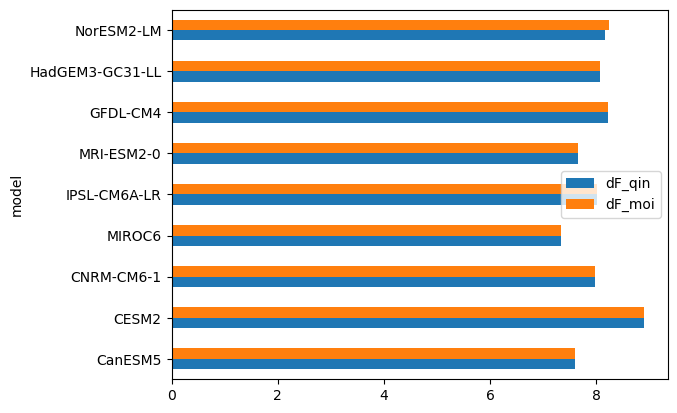

In [21]:
# Consistency with Qin et al. 2022
df_qin = pd.read_csv('/homedata/rguillaume/data/Radiative_response_dynamics/Application_transient_response/input/yi_qin_2022_ERF_data.csv', index_col=0).reset_index()
df_qin[['model','realisation']] = df_qin['index'].str.split('_', expand=True)
df_qin = df_qin.groupby('model').first().sstClim.dropna().loc[models]
df_compare = pd.DataFrame(dict(dF_qin = df_qin, dF_moi=dF.interp(time=np.log(4)/np.log(1.01)).to_series()))
df_compare.plot.barh()
# OK

In [6]:
model = 'IPSL-CM6A-LR'

paths_model = all_model_path.loc[all_model_path.model==model]
######### Get TOS data ###########
# Load datasets
tos_1pctCO2 = open_cmip6_data(paths_model.loc[(paths_model.experiment=='1pctCO2') & (paths_model.variable=='tos')].path.iloc[0])
tos_control = open_cmip6_data(paths_model.loc[(paths_model.experiment=='piControl') & (paths_model.variable=='tos')].path.iloc[0]).isel(time=range(tos_1pctCO2.time.size))
if model == 'GISS-E2-1-G':
    areacello = np.cos(np.deg2rad(tos_control.y))
else:
    areacello = open_cmip6_data(paths_model.loc[(paths_model.variable=='areacello') ].path.iloc[0]).areacello.fillna(0)
if model == 'BCC-CSM2-MR':
    tos_control = tos_control.rename(longitude='lon', latitude='lat')
    tos_1pctCO2 = tos_1pctCO2.rename(longitude='lon', latitude='lat')
if model == 'E3SM-1-0':
    # tos_1pctCO2 = tos_1pctCO2.drop(['member_id', '1dcpp_init_year']).squeeze()
    tos_control = tos_control.drop(['member_id', 'dcpp_init_year']).squeeze()
print('datasets loaded')
# Resample to get yearly datasets
tos_control_y = tos_control.groupby('time.year').mean(keep_attrs=True).rename(year='time')
tos_1pctCO2_y = tos_1pctCO2.groupby('time.year').mean(keep_attrs=True).rename(year='time')
tos_control_y['time'] = np.arange(tos_control_y.time.size)
tos_1pctCO2_y['time'] = np.arange(tos_1pctCO2_y.time.size)
# tos_control_y['time'] = tos_control_y.time.size
# tos_1pctCO2_y['time'] = tos_control_y.time.size
print('yearly comoputed')
# Make global averages
tos_control_mean_y = tos_control_y.weighted(areacello).mean(['x','y'], keep_attrs=True)
tos_1pctCO2_mean_y = tos_1pctCO2_y.weighted(areacello).mean(['x','y'], keep_attrs=True)
print('Global averages ok')
# Compute drift
drift_control_tos_1pctCO2 = tos_control_mean_y.tos.polyfit('time', deg=1).polyfit_coefficients.sel(degree=1, drop=True)
reference_tos = tos_control_mean_y.isel(time=range(10)).mean('time')
dtos_1pctCO2_y = tos_1pctCO2_mean_y - drift_control_tos_1pctCO2*tos_1pctCO2_mean_y.time - reference_tos
reference_tos_grid = tos_control_y.isel(time=range(10)).mean('time')

dtos_1pctCO2_y_grid = tos_1pctCO2_y - drift_control_tos_1pctCO2*tos_1pctCO2_y.time - reference_tos_grid
# Compute SST pattern as local warming minus global warming
pattern_tos_1pct = (dtos_1pctCO2_y_grid - dtos_1pctCO2_y)
# Regrid on a single 2°x2 grid
new_grid = xe.util.grid_global(2, 2)
regridder = xe.Regridder(pattern_tos_1pct.rename(lon_bounds='lon_b', lat_bounds='lat_b'), new_grid, "conservative_normed", periodic=True, ignore_degenerate=True)
# make final tos_dataset
ds_tos = xr.Dataset(dict(tos_control_grid = regridder(tos_control_y.isel(time=range(10)).mean('time')).tos,
                        dtos_1pctCO2_grid = regridder(dtos_1pctCO2_y_grid).tos,
                        dtos_1pctCO2 = dtos_1pctCO2_y.tos,
                        pattern_tos_1pct = regridder(pattern_tos_1pct))).tos.load()\
                            .assign_coords(model=model, time=np.arange(dtos_1pctCO2_y.time.size))

/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate

datasets loaded
yearly comoputed


HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

Global averages ok


HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 27:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 27:
  #000: H5A.c line 528 in H5

In [10]:
regridder = xe.Regridder(pattern_tos_1pct.rename(lon_bounds='lon_b', lat_bounds='lat_b').isel(time=0), new_grid, "conservative_normed", periodic=True, ignore_degenerate=True)


KeyboardInterrupt: 

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/asyncio/runners.py", line 44, in run
    return loop.run_until_complete(main)
  File "/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/asyncio/base_events.py", line 1871, in _run_once
    event_list = self._selector.select(timeout)
  File "/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/selectors.py", line 469, in select
    fd_event_list = self._selector.poll(ti

In [8]:
ds_tos

NameError: name 'ds_tos' is not defined